In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
notebook = "real3_CalHousing_init"

In [3]:
import numpy as np

experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()

n_runs = metadata['n_runs']

## Sigmas & RMSE

Run 0: MTMH BART first reached within 1.0% of mode at iteration 4489; Default BART at iteration 5216
Run 1: MTMH BART first reached within 1.0% of mode at iteration 3880; Default BART at iteration 5370
Run 2: MTMH BART first reached within 1.0% of mode at iteration 5052; Default BART at iteration 5219
Run 3: MTMH BART first reached within 1.0% of mode at iteration 5794; Default BART at iteration 6304
Run 4: MTMH BART first reached within 1.0% of mode at iteration 5458; Default BART at iteration 6051


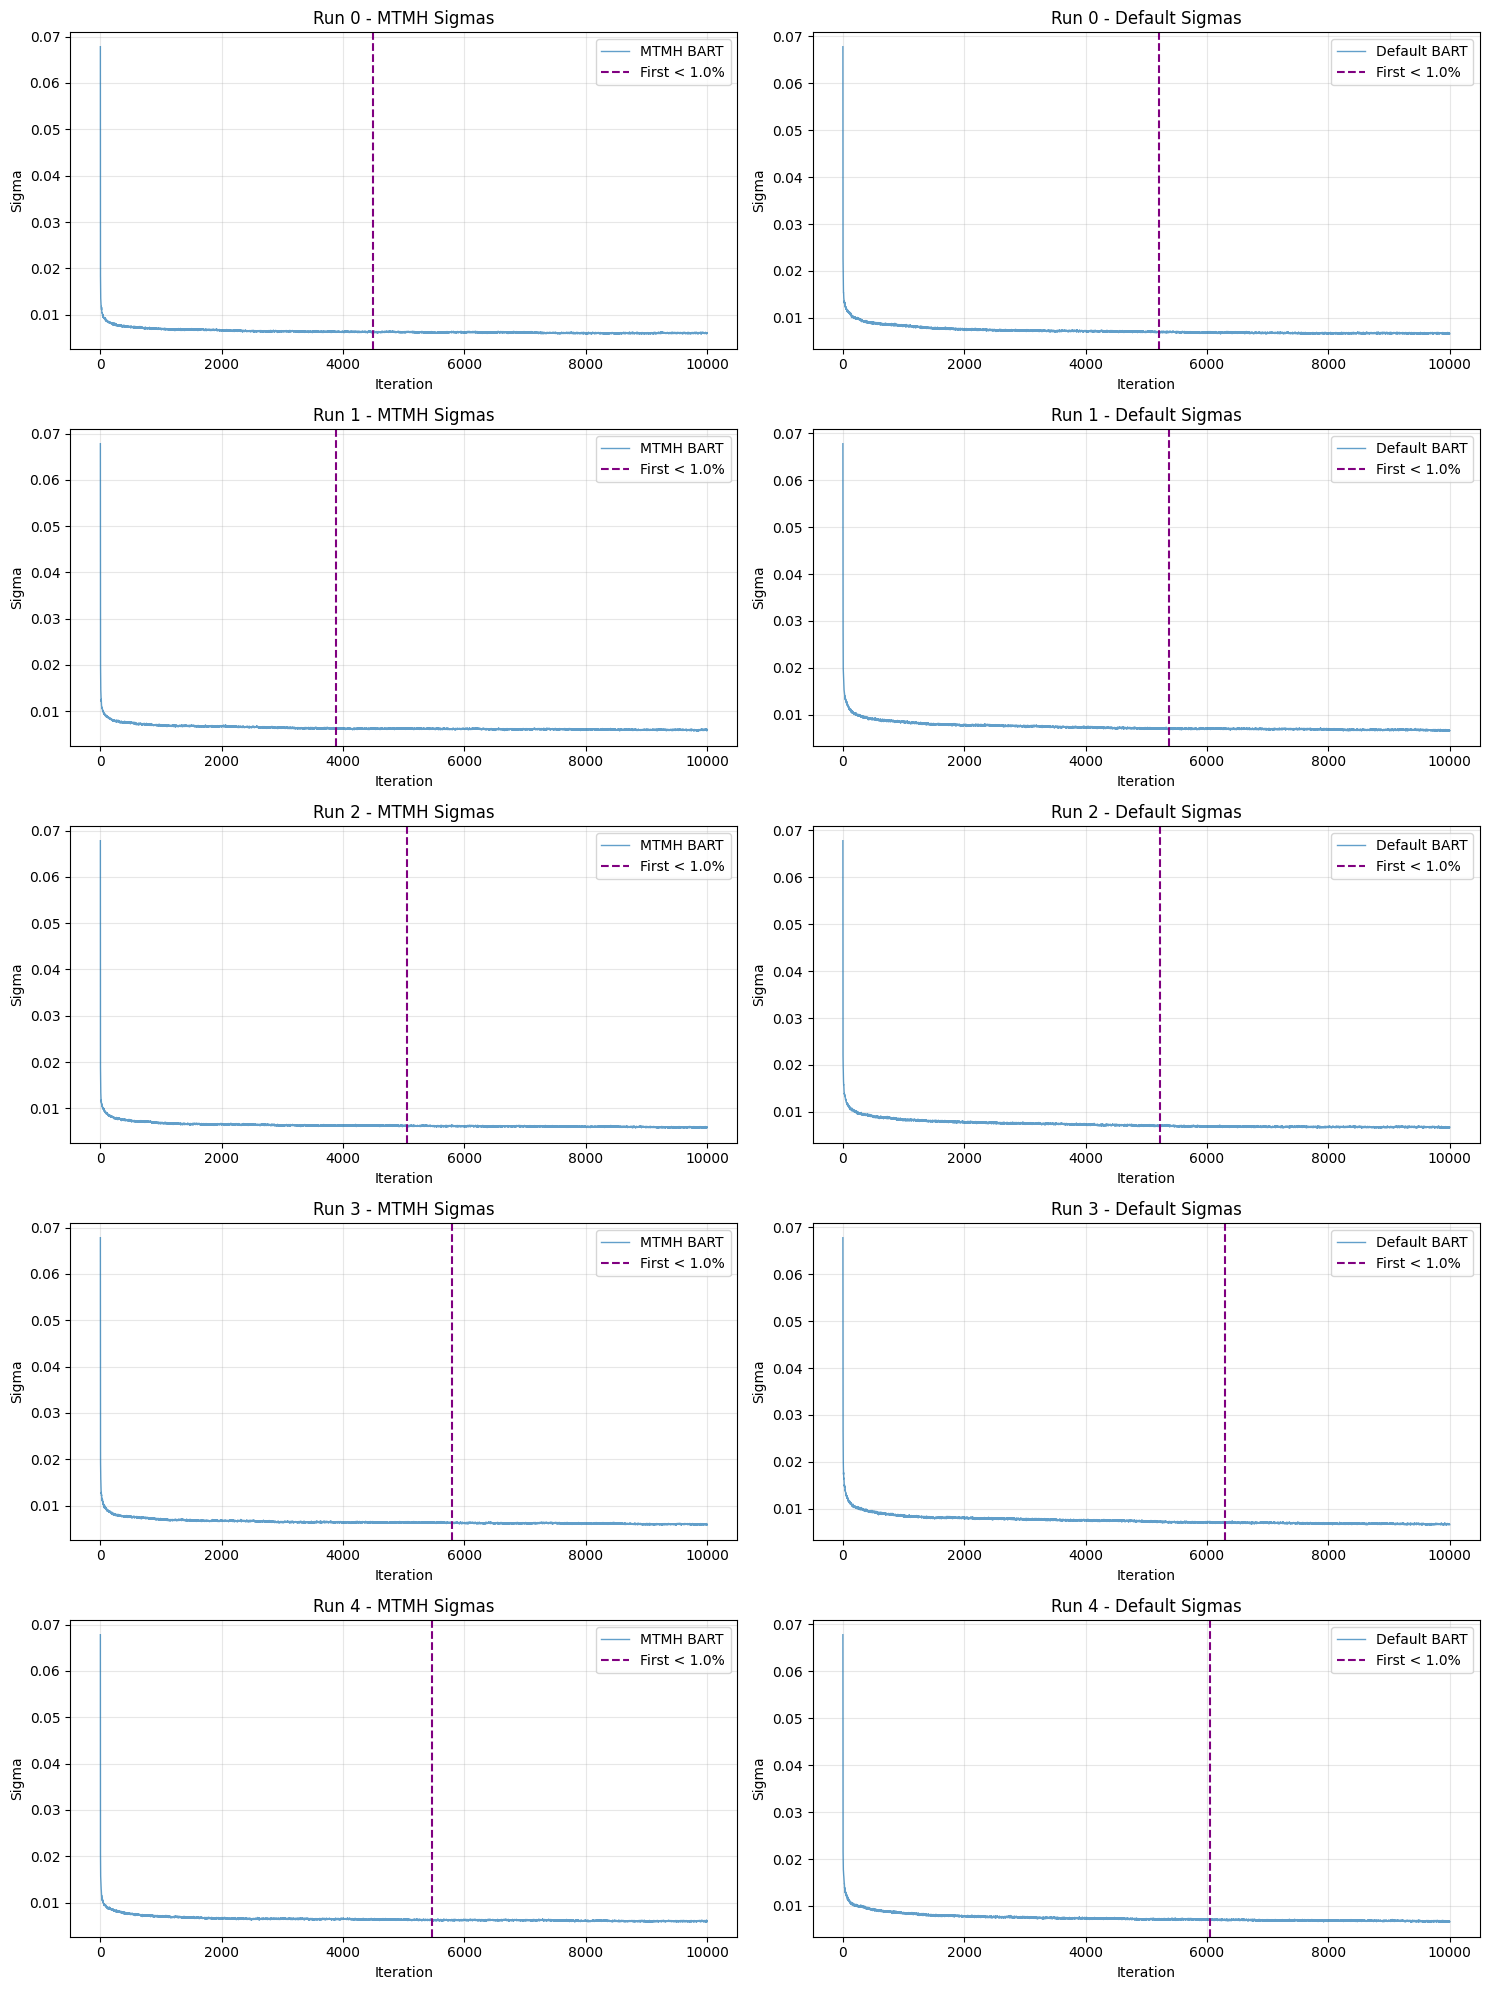

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

# Use a relative threshold: e.g., 1% of the estimated mode value
relative_threshold = 0.01

for run_id in range(n_runs):
    # Get sigmas for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id][0]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id][0]

    # Estimate mode using the mean of the last 2000 samples
    default_mode = np.mean(default_sigmas[-2000:])
    mtmh_mode = np.mean(mtmh_sigmas[-2000:])

    # Calculate distance to mode
    default_dist = np.abs(default_sigmas - default_mode)
    mtmh_dist = np.abs(mtmh_sigmas - mtmh_mode)

    # Use relative threshold for convergence
    default_threshold = relative_threshold * np.abs(default_mode)
    mtmh_threshold = relative_threshold * np.abs(mtmh_mode)

    # Find the first iteration where distance to mode is less than the threshold
    default_first = np.argmax(default_dist < default_threshold)
    mtmh_first = np.argmax(mtmh_dist < mtmh_threshold)

    print(f'Run {run_id}: MTMH BART first reached within {relative_threshold*100:.1f}% of mode at iteration {mtmh_first}; Default BART at iteration {default_first}')

    # Left plot: MTMH BART
    axes[run_id, 0].plot(mtmh_sigmas, label='MTMH BART', alpha=0.7, linewidth=1)
    # axes[run_id, 0].plot(mtmh_mode * np.ones_like(mtmh_sigmas), 'r--', label='Mode (last 2000 mean)')
    axes[run_id, 0].axvline(mtmh_first, color='purple', linestyle='--', label=f'First < {relative_threshold*100:.1f}%')
    axes[run_id, 0].set_title(f'Run {run_id} - MTMH Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigma')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Right plot: Default BART
    axes[run_id, 1].plot(default_sigmas, label='Default BART', alpha=0.7, linewidth=1)
    # axes[run_id, 1].plot(default_mode * np.ones_like(default_sigmas), 'r--', label='Mode (last 2000 mean)')
    axes[run_id, 1].axvline(default_first, color='purple', linestyle='--', label=f'First < {relative_threshold*100:.1f}%')
    axes[run_id, 1].set_title(f'Run {run_id} - Default Sigmas')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Sigma')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Run 0: MTMH BART first stable window (±10%) starts at 2398; Default BART at 3264
Run 1: MTMH BART first stable window (±10%) starts at 2869; Default BART at 4162
Run 2: MTMH BART first stable window (±10%) starts at 2560; Default BART at 3981
Run 3: MTMH BART first stable window (±10%) starts at 2879; Default BART at 4995
Run 4: MTMH BART first stable window (±10%) starts at 2464; Default BART at 4020


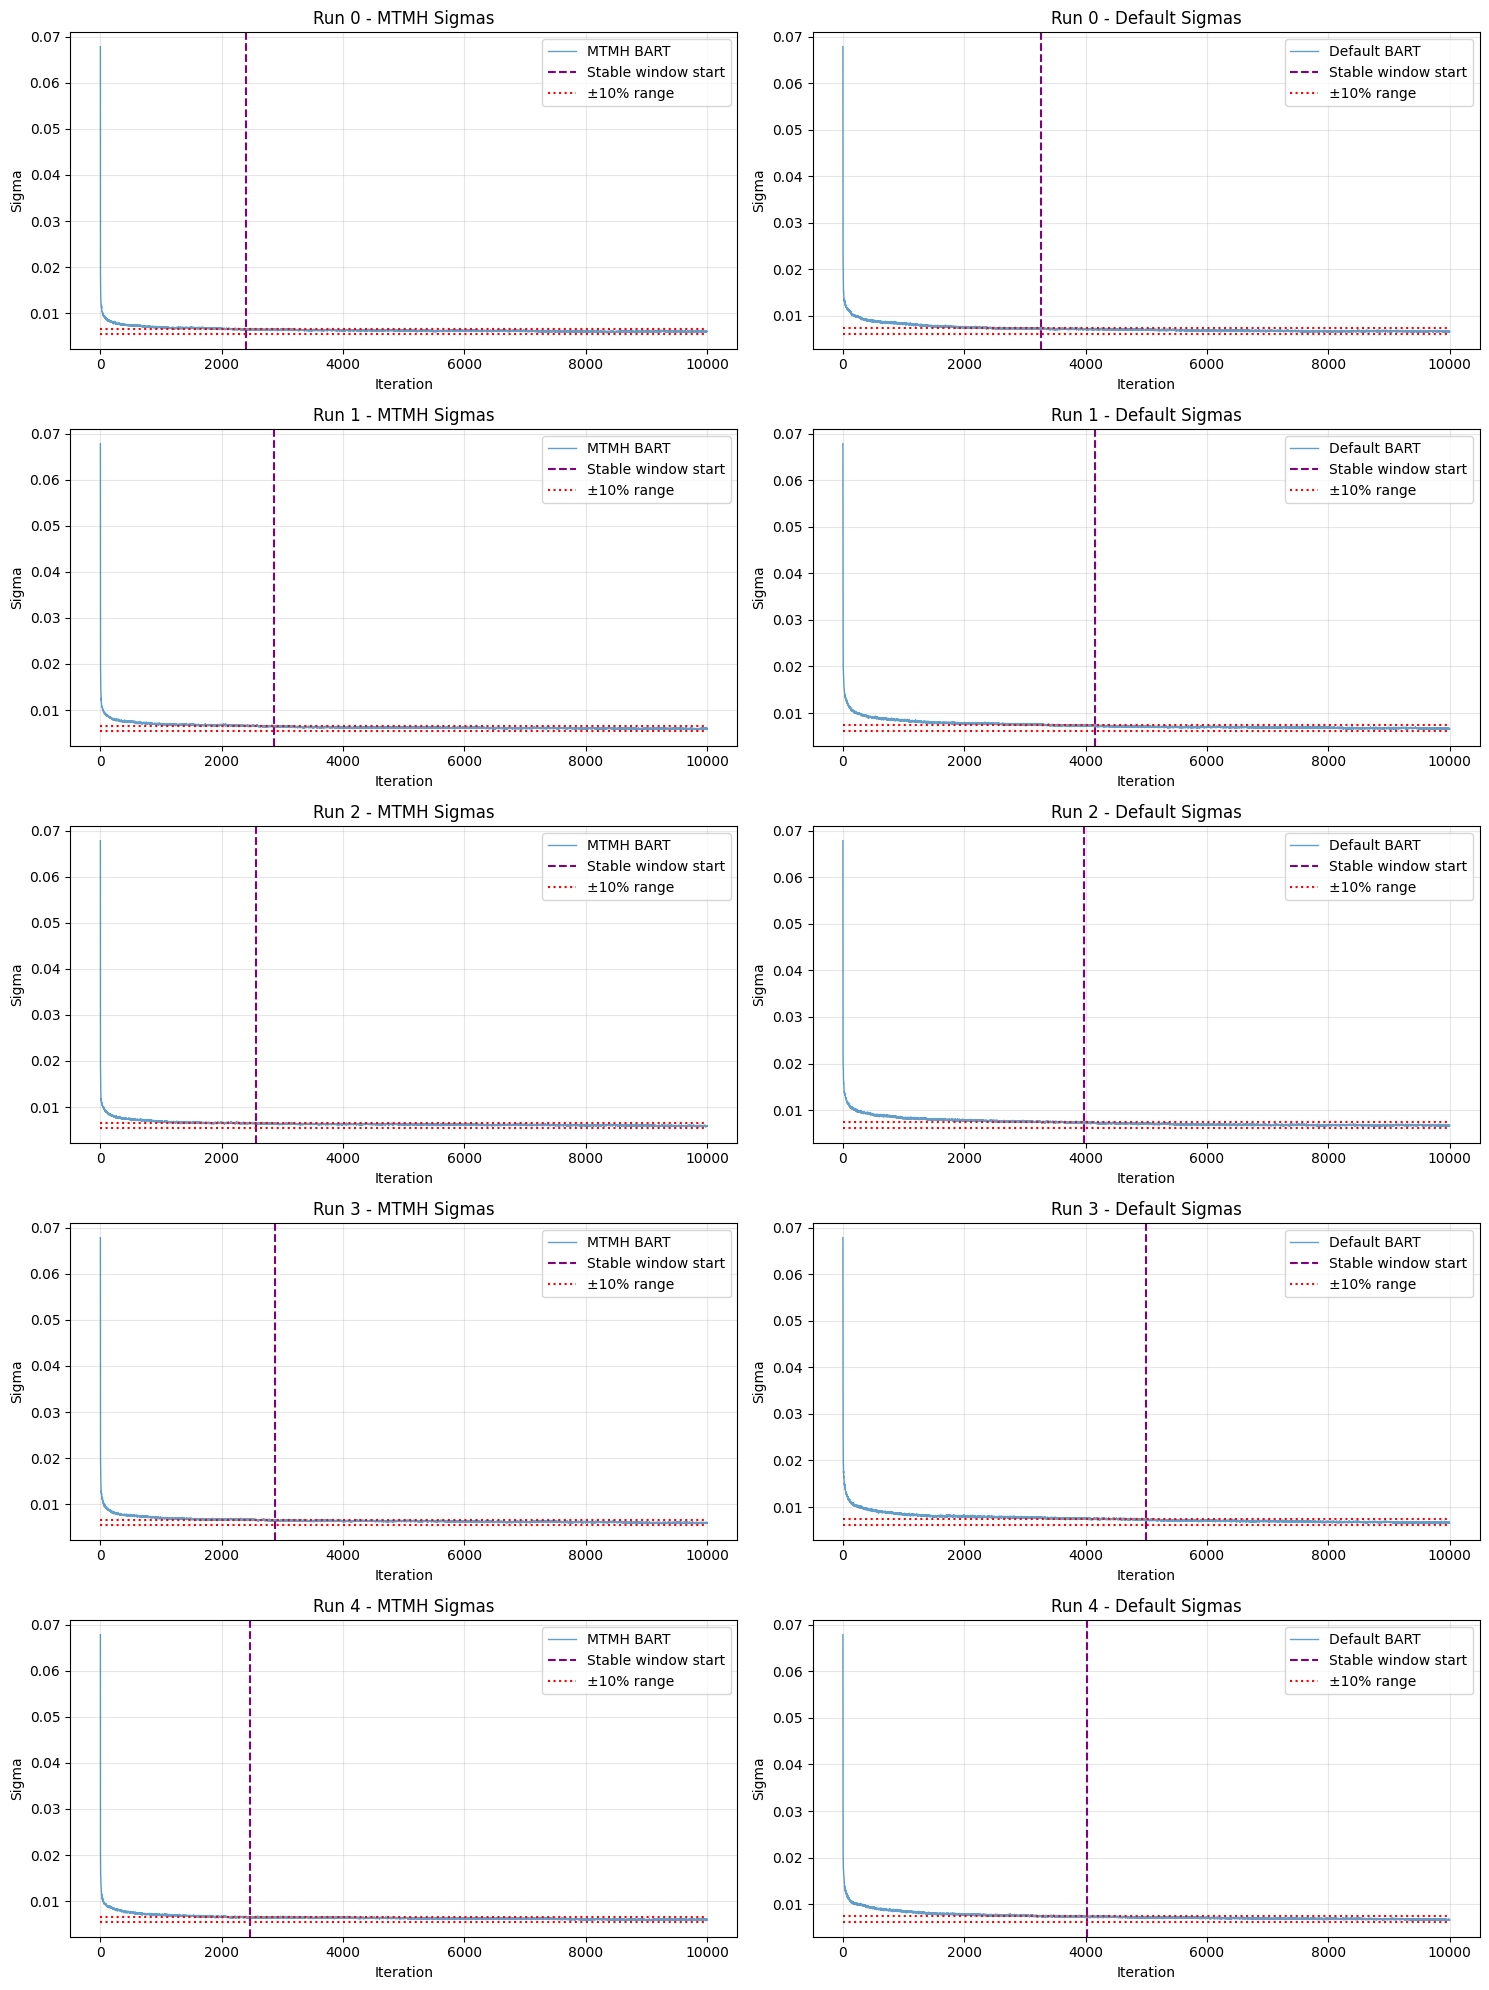

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

window_size = 50  # Number of consecutive steps
percent_range = 0.10  # +/-10% range

for run_id in range(n_runs):
    # Get sigmas for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id][0]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id][0]

    # Estimate mode using the mean of the last 2000 samples
    default_mode = np.mean(default_sigmas[-2000:])
    mtmh_mode = np.mean(mtmh_sigmas[-2000:])

    # Calculate lower and upper bounds
    default_lower = default_mode * (1 - percent_range)
    default_upper = default_mode * (1 + percent_range)
    mtmh_lower = mtmh_mode * (1 - percent_range)
    mtmh_upper = mtmh_mode * (1 + percent_range)

    # Find first window where all values are within bounds
    def find_stable_window(arr, lower, upper, window):
        for i in range(len(arr) - window + 1):
            if np.all((arr[i:i+window] >= lower) & (arr[i:i+window] <= upper)):
                return i
        return -1

    default_stable = find_stable_window(default_sigmas, default_lower, default_upper, window_size)
    mtmh_stable = find_stable_window(mtmh_sigmas, mtmh_lower, mtmh_upper, window_size)

    print(f'Run {run_id}: MTMH BART first stable window (±{percent_range*100:.0f}%) starts at {mtmh_stable}; Default BART at {default_stable}')

    # Left plot: MTMH BART
    axes[run_id, 0].plot(mtmh_sigmas, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].axvline(mtmh_stable, color='purple', linestyle='--', label=f'Stable window start')
    axes[run_id, 0].hlines([mtmh_lower, mtmh_upper], 0, len(mtmh_sigmas), colors='r', linestyles='dotted', label='±10% range')
    axes[run_id, 0].set_title(f'Run {run_id} - MTMH Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigma')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Right plot: Default BART
    axes[run_id, 1].plot(default_sigmas, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].axvline(default_stable, color='purple', linestyle='--', label=f'Stable window start')
    axes[run_id, 1].hlines([default_lower, default_upper], 0, len(default_sigmas), colors='r', linestyles='dotted', label='±10% range')
    axes[run_id, 1].set_title(f'Run {run_id} - Default Sigmas')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Sigma')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()